
### BID DATA ANALYTICS PROJECT
+ Name: **Jude Gbenimako**
+ Student ID: **20240700**
+ Group: **40**

+ ## Project Title and Objective

## Multi-Class Text Classification of Udemy Courses using Spark NLP & MLlib

This project aims to classify Udemy courses into their correct subject categories based on their titles using distributed machine learning in PySpark. 

The goal is to explore various modeling approaches (Logistic Regression, Naive Bayes, Random Forest), tune parameters, and evaluate their classification performance.


+ ## Data Description

##### About this Data
This dataset contains detailed information about courses available on Udemy, one of the largest online learning platforms. It includes course metadata such as titles, instructors, categories, ratings, subscriber counts, and more. The dataset is ideal for analyzing trends in online education, understanding user preferences, recommendation systems, and exploring course content for research and classification tasks.

**Key features of the dataset:**

Over 98,000 courses across various subject categories and difficulty levels.
Detailed course information, including ratings, reviews, and enrollment numbers.
Perfect for data analysis, machine learning projects, or market insights into the e-learning industry.
Udemy is a massive online open course (MOOC) platform that offers both free and paid courses. The business type is Freemium e-Learning Marketplace (with Tiered Monetization), combining a freemium model with a platform-based digital education business. Anybody can create a course, a business model that allowed Udemy to have hundreds of thousands of courses.

The dataset is publicly available at:
https://www.kaggle.com/datasets/emrebayirr/udemy-course-dataset-categories-ratings-and-trends/data 

It is an overview of Udemy Courses Data extracted from 2010 to 2023

+ ## Tools and Environment

- **Databricks Community Edition**
- **PySpark:** for distributed processing
- **Spark MLlib:** for model training
- **Spark NLP:** for text preprocessing
- **matplotlib/seaborn:** Some python stack libraries were used sparingly for visualization
- **My Cluster configuration:** Runtime: 12.2 LTS (Scala 2.12, Spark 3.3.2)- Databricks Runtime for Machine Learning, which was the fastest in my Laptop



# 1. Import packages

In [0]:
#### Data manipulation and utility libraries ####
import pandas as pd
import numpy as np
import string
import re
from collections import Counter
import os

#### Visualization libraries ####
import matplotlib.pyplot as plt
import seaborn as sns

#### PySpark core functions & types ####
import pyspark.sql.functions as F
from pyspark.sql.functions import (
    col,
    avg,
    when,
    lower,
    regexp_replace,
    trim,
    explode,
    split,
    count,
    sum,
    udf,
    desc,
    row_number,
    length
)
from pyspark.sql.types import StringType
from pyspark.sql.window import Window

#### PySpark ML pipeline components ####
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    Tokenizer,
    StopWordsRemover,
    NGram,
    SQLTransformer,
    CountVectorizer,
    IDF,
    StringIndexer
)
from pyspark.ml.classification import (
    LogisticRegression,
    NaiveBayes,
    RandomForestClassifier
)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


## 2. Reading the Data

In [0]:
# for clear display of the dataset
df = (
    spark.read.format("csv")
    .option("header", "true")
    .option("inferSchema", "true")
    .option("multiLine", "true")        # Handle multiline rows
    .option("quote", '"')               # Handle quoted fields
    .option("escape", '"')              # Escape quotes properly
    .load("/FileStore/tables/udemy__courses.csv")
)
display(df)

id title url is_paid instructor_names category headline num_subscribers rating num_reviews instructional_level objectives curriculum 567828 The Complete Python Bootcamp From Zero to Hero in Python https://www.udemy.com/course/complete-python-bootcamp/ true Jose Portilla, Pierian Training Development Learn Python like a Professional Start from the basics and go all the way to creating your own applications and games 1976866 4.576494 521219 All Levels You will learn how to leverage the power of Python to solve tasks. You will build games and programs that use Python libraries. You will be able to use Python for your own work problems or personal projects. Course Overview, Auto-Welcome Message, Course Introduction, Course Curriculum Overview, Why Python?, Course FAQs, Python Setup, Command Line Basics, Installing Python (Step by Step), Running Python Code, Getting the Notebooks and the Course Material, Git and Github Overview (Optional), Python Object and Data Structure Basics, Introduction to Python Data Types, Python Numbers, Numbers: Simple Arithmetic, Numbers - FAQ, Numbers Quiz, Variable Assignments, Introduction to Strings, Quick Print Check, Indexing and Slicing with Strings, String Indexing, String Slicing, String Properties and Methods, Strings -FAQ, Strings Quiz, Print Formatting with Strings, Print Formatting FAQs, Print Formatting, Lists in Python, Lists, Lists - FAQ, Lists Quiz, Dictionaries in Python, Dictionaries, Dictionaries - FAQ, Dictionaries Quiz, Tuples with Python, Tuples Quiz, Sets in Python, Sets, Booleans in Python, Sets and Booleans Quiz, I/O with Basic Files in Python, File I/O, Resources for More Basic Practice, Python Objects and Data Structures Assessment Test Overview, Python Objects and Data Structures Assessment Test Solutions, Python Comparison Operators, Comparison Operators in Python, Chaining Comparison Operators in Python with Logical Operators, Comparison Operators Quiz, Python Statements, If Elif and Else Statements in Python, For Loops in Python, While Loops in Python, Useful Operators in Python, List Comprehensions in Python, Python Statements Test Overview, Python Statements Test Solutions, Methods and Functions, Methods and the Python Documentation, Introduction to Functions, def Keyword, Basics of Python Functions, Logic with Python Functions, Tuple Unpacking with Python Functions, Interactions between Python Functions, Overview of Quick Function Exercises #1-10, Quick Check on Solutions Link, Functions #1: print Hello World, Functions #2: print Hello Name, Functions #3 - simple Boolean, Functions #4 - using Booleans, Functions #5: simple math, Functions #6: is even, Functions #7: is greater, *args and **kwargs in Python, Functions #8: *args, Functions #9: pick evens, Functions #10: skyline, Function Practice Exercises - Overview, Function Practice Exercises - Solutions, Function Practice - Solutions Level One, Function Practice - Solutions Level Two, Function Exercise Solutions - Challenge Problem, Lambda Expressions, Map, and Filter Functions, Nested Statements and Scope, Methods and Functions Homework Overview, Methods and Functions Homework - Solutions, Milestone Project - 1, Introduction to Warm Up Project Exercises, Displaying Information, Accepting User Input, Validating User Input, Simple User Interaction, First Python Milestone Project Overview, Milestone Project Help, Solution Overview for MileStone Project 1 - Part One, Solution Overview for MileStone Project 1 - Part Two, Object Oriented Programming, Object Oriented Programming - Introduction, Object Oriented Programming - Attributes and Class Keyword, Object Oriented Programming - Class Object Attributes and Methods, Object Oriented Programming - Inheritance and Polymorphism, Object Oriented Programming - Special (Magic/Dunder) Methods, Object Oriented Programming - Homework, Object Oriented Programming - Homework Solutions, Object Oriented Programming - Challenge Overview, Object Oriented Programming - Challenge Solution,

#3. Exploratory data analysis

In [0]:
# Check number of rows and columns in our dataset
print("Shape of our dataset is:")
print("Rows:", df.count(), ", Columns:", len(df.columns))

Shape of our dataset is:
Rows: 98104 , Columns: 13


### The structure and data types of all the columns in the dataset

In [0]:
print("Schema of dataset:")
df.printSchema()

Schema of dataset:
root
 |-- id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- is_paid: boolean (nullable = true)
 |-- instructor_names: string (nullable = true)
 |-- category: string (nullable = true)
 |-- headline: string (nullable = true)
 |-- num_subscribers: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- num_reviews: integer (nullable = true)
 |-- instructional_level: string (nullable = true)
 |-- objectives: string (nullable = true)
 |-- curriculum: string (nullable = true)



In [0]:
# Rename relevant columns
df = df.withColumnRenamed("id", "course_id") \
       .withColumnRenamed("title", "course_title") \
       .withColumnRenamed("category", "subject")

df.select("course_id", "course_title", "subject").show(5, truncate=False)


+---------+--------------------------------------------------------+-----------+
|course_id|course_title                                            |subject    |
+---------+--------------------------------------------------------+-----------+
|567828   |The Complete Python Bootcamp From Zero to Hero in Python|Development|
|1565838  |The Complete 2024 Web Development Bootcamp              |Development|
|2776760  |100 Days of Code: The Complete Python Pro Bootcamp      |Development|
|625204   |The Web Developer Bootcamp 2024                         |Development|
|1362070  |React - The Complete Guide 2024 (incl. Next.js, Redux)  |Development|
+---------+--------------------------------------------------------+-----------+
only showing top 5 rows



### I renamed and selected these relevant columns (id, tittle and category) for the following reasons:

 - Clarity — course_id is more descriptive than just id
 - Usability — subject makes the classification target clear and it is not a  Python keywords like category in Pandas or Spark MLlib.

-  Consistency — course_title column aligns with NLP tasks

 

In [0]:
# comfirm renaming action
print("Schema of dataset:")
df.printSchema()

Schema of dataset:
root
 |-- course_id: integer (nullable = true)
 |-- course_title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- is_paid: boolean (nullable = true)
 |-- instructor_names: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- headline: string (nullable = true)
 |-- num_subscribers: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- num_reviews: integer (nullable = true)
 |-- instructional_level: string (nullable = true)
 |-- objectives: string (nullable = true)
 |-- curriculum: string (nullable = true)



Further analysis will be done on selected relevant columns based on the aim of our project implementation.

### Check for Duplicate Course Titles

In [0]:
# Check for duplicate rows based on the selected columns
duplicate_count = df.groupBy("course_id", "course_title", "subject") \
    .count() \
    .filter("count > 1") \
    .count()

print(f"Number of duplicate rows: {duplicate_count}")


Number of duplicate rows: 0


There are no duplicates of course title from the same author/instructor in the same subject. This is important to implement an unbias classification.

# 4. Pre Processing

Based on our interest to classify course titles to their appriopriate subject category for easy search and location by users, we are only interested in the course title and subject category.

So we will select these two relevant columns.

In [0]:
# Keep only the two relevant columns and update df
df = df.select("course_title", "subject")
df.columns

Out[75]: ['course_title', 'subject']

In [0]:
# Check number of rows and columns in our dataset
print("Shape of our dataframe is:")
print("Rows:", df.count(), ", Columns:", len(df.columns))

Shape of our dataframe is:
Rows: 98104 , Columns: 2


In [0]:
# Confirm the new DataFrame and preview full string values
df.show(5, truncate=False)

+--------------------------------------------------------+-----------+
|course_title                                            |subject    |
+--------------------------------------------------------+-----------+
|The Complete Python Bootcamp From Zero to Hero in Python|Development|
|The Complete 2024 Web Development Bootcamp              |Development|
|100 Days of Code: The Complete Python Pro Bootcamp      |Development|
|The Web Developer Bootcamp 2024                         |Development|
|React - The Complete Guide 2024 (incl. Next.js, Redux)  |Development|
+--------------------------------------------------------+-----------+
only showing top 5 rows



In [0]:
#  subjects by count
df.groupBy('subject').count().orderBy("count", ascending=False).show()

+--------------------+-----+
|             subject|count|
+--------------------+-----+
|         Development| 9945|
|            Business| 9912|
|       IT & Software| 9888|
|Teaching & Academics| 9763|
|Personal Development| 9692|
|              Design| 9263|
|    Health & Fitness| 8559|
|           Lifestyle| 7426|
|Finance & Accounting| 7324|
|           Marketing| 6277|
| Office Productivity| 3955|
|               Music| 3854|
| Photography & Video| 2246|
+--------------------+-----+



Quick check of the distribution of subject category in our dataset by ranking  counts, show Class imbalance which we will investigate later.


# Data Cleaning 

### Check for missing values

In [0]:

# Count nulls in each column
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()


+------------+-------+
|course_title|subject|
+------------+-------+
|           0|      0|
+------------+-------+



There is no missing values in course title and subject category.

In [0]:
# Preview for a check of special characters
df.select("course_title","subject" ).show(20, truncate=False)


+------------------------------------------------------------+-----------+
|course_title                                                |subject    |
+------------------------------------------------------------+-----------+
|The Complete Python Bootcamp From Zero to Hero in Python    |Development|
|The Complete 2024 Web Development Bootcamp                  |Development|
|100 Days of Code: The Complete Python Pro Bootcamp          |Development|
|The Web Developer Bootcamp 2024                             |Development|
|React - The Complete Guide 2024 (incl. Next.js, Redux)      |Development|
|The Complete JavaScript Course 2024: From Zero to Expert!   |Development|
|Angular - The Complete Guide (2024 Edition)                 |Development|
|Java 17 Masterclass: Start Coding in 2024                   |Development|
|Machine Learning A-Z: AI, Python & R + ChatGPT Prize [2024] |Development|
|Python for Data Science and Machine Learning Bootcamp       |Development|
|The Data Science Course:

## **Observation:**
There are presence of Special Characters, course title such as  :, -, &, %, and !.

We will keep only the english alphabets, normal spaces and domain characters("#" in C#, "+" in C++, etc)

Puctuations and numbers are not  meaningful and will introduce noise for NLP classification.



These unwanted characters inflate vocabulary size unnecessarily during tokenization and will be investigated and removed next.

No unexpected symbols appeared in the output, the subject column appears clean but we will investigate further.

%md
##Count character frequency in course_title to understand these unwanted character

In [0]:
# Extract all characters into individual rows
char_df = df.select(
    explode(
        split(lower(col("course_title")), "")
    ).alias("char")
)

# Group and count unique characters
char_counts = char_df.groupBy("char").count().orderBy("count", ascending=False)

# Show all unique characters with frequency
char_counts.show(1000, truncate=False)


+----+------+
|char|count |
+----+------+
|    |599231|
|e   |416857|
|a   |320560|
|i   |309964|
|t   |302116|
|n   |285356|
|o   |277449|
|r   |270016|
|s   |262296|
|c   |180538|
|l   |157581|
|d   |122293|
|m   |119417|
|g   |116882|
|p   |112302|
|u   |110205|
|h   |91776 |
|f   |75374 |
|b   |60372 |
|y   |56790 |
|w   |46304 |
|v   |38625 |
|k   |32926 |
|-   |25361 |
|:   |22929 |
|2   |15498 |
|0   |14455 |
|x   |13914 |
|1   |12277 |
|&   |11034 |
|,   |8743  |
|j   |8536  |
|(   |7397  |
|)   |7396  |
|q   |6537  |
|3   |6088  |
|z   |5821  |
|.   |5006  |
|4   |4680  |
|5   |3552  |
|!   |3421  |
||   |2709  |
|/   |2705  |
|+   |2659  |
|6   |2190  |
|'   |2091  |
|7   |1652  |
|9   |1340  |
|8   |1251  |
|#   |827   |
|"   |675   |
|[   |657   |
|]   |656   |
|?   |425   |
|–   |361   |
|_   |343   |
|®   |260   |
|ا   |185   |
|’   |171   |
|™   |170   |
|ل   |146   |
|;   |145   |
|%   |121   |
|*   |116   |
|ي   |96    |
|ت   |78    |
|م   |78    |
|ر   |73    |
|و   |

#Observations:
- The most frequent characters were standard English letters (e.g., e, a, t, etc.), which is expected.
- However, we also detected unwanted characters including:
- Punctuation and symbols: !, #, -, &, @, etc.
- Digits: 0–9, which are not meaningful in this context.
- Accented characters and foreign scripts (e.g., é, ç, 日, ب, ア), indicating multilingual course titles.

This is very helpful for text data like course title, so we can see the unique characters to help us decide which unwanted characters to remove.

## Cleaning Strategy:
To simplify and standardize the text for NLP and classification, we applied the following cleaning steps:
- Converted all course titles to lowercase.
- Removed all unwanted characters except English alphabets,  spaces and domain characters

This is to ensure that the resulting text is clean, consistent, and optimized for further NLP processing like tokenization, vectorization, and model training.

##Using regex pattern to remove the wrong characters in course title column.

In [0]:

# Regex cleaning
df = df.withColumn(
    "course_title",
    trim(
        regexp_replace(
            regexp_replace(
                lower(regexp_replace(col("course_title"), "<.*?>", "")),  # remove HTML tags
                "[^a-zA-Z+#.]", " "  # remove everything except letters, +, #, .
            ),
            "\s+", " "  # normalize whitespace
        )
    )
)

# Remove short words (< 2 characters) to retain important tokens (eg., C#, web, C++, etc) only
def clean_tokens(text):
    if not text:
        return ""
    return " ".join([word for word in text.split() if len(word) >= 2])

clean_tokens_udf = udf(clean_tokens, StringType())

df = df.withColumn("course_title", clean_tokens_udf(col("course_title")))

# Preview
df.select("course_title").show(10, truncate=False)


+--------------------------------------------------------+
|course_title                                            |
+--------------------------------------------------------+
|the complete python bootcamp from zero to hero in python|
|the complete web development bootcamp                   |
|days of code the complete python pro bootcamp           |
|the web developer bootcamp                              |
|react the complete guide incl. next.js redux            |
|the complete javascript course from zero to expert      |
|angular the complete guide edition                      |
|java masterclass start coding in                        |
|machine learning ai python chatgpt prize                |
|python for data science and machine learning bootcamp   |
+--------------------------------------------------------+
only showing top 10 rows



In [0]:

# Remove rows where course_title is null, empty, or only whitespace
df = df.filter(trim(col("course_title")) != "")

To filter out invalid or useless rows in our DataFrame by cleaning the course_title column

##Verify the removal of unwanted characters in course title

In [0]:

# Step 1: Extract all characters into individual rows
char_df = df.select(
    explode(
        split(lower(col("course_title")), "")
    ).alias("char")
)

# Step 2: Group and count unique characters
char_counts = char_df.groupBy("char").count().orderBy("count", ascending=False)

# Step 3: Show all unique characters with frequency
char_counts.show(1000, truncate=False)


+----+------+
|char|count |
+----+------+
|    |536296|
|e   |416504|
|a   |311022|
|i   |309486|
|t   |301891|
|n   |285247|
|o   |277385|
|r   |269663|
|s   |260088|
|c   |179901|
|l   |157385|
|d   |120650|
|m   |119204|
|g   |116749|
|p   |112117|
|u   |110175|
|h   |91704 |
|f   |75278 |
|b   |59919 |
|y   |56784 |
|w   |46120 |
|v   |38231 |
|k   |32817 |
|x   |13496 |
|j   |8517  |
|q   |6446  |
|z   |5249  |
|.   |3723  |
|+   |1147  |
|#   |467   |
+----+------+



In [0]:
df = df.select('course_title', 'subject') 
df.show(20, truncate=False)                 


+----------------------------------------------------------+-----------+
|course_title                                              |subject    |
+----------------------------------------------------------+-----------+
|the complete python bootcamp from zero to hero in python  |Development|
|the complete web development bootcamp                     |Development|
|days of code the complete python pro bootcamp             |Development|
|the web developer bootcamp                                |Development|
|react the complete guide incl. next.js redux              |Development|
|the complete javascript course from zero to expert        |Development|
|angular the complete guide edition                        |Development|
|java masterclass start coding in                          |Development|
|machine learning ai python chatgpt prize                  |Development|
|python for data science and machine learning bootcamp     |Development|
|the data science course complete data science boot

The course title  and subject are clean of unwanted characters and ready for further processing.

In [0]:
# Check number of rows and columns in our dataframe
print("Shape of our dataframe is:")
print("Rows:", df.count(), ", Columns:", len(df.columns))


Shape of our dataframe is:
Rows: 98073 , Columns: 2


98,104 records has been cleaned down to 98,073  after removing malformed rows.

With 98,073 course titles and multiple classes, the dataset’s high-dimensional  features make it well-suited 
for scalable processing. 

As noted in https://spark.apache.org/docs/latest/ml-guide.html , Spark ML pipelines 
are ideal as the sized is good enough for text classification tasks in both training and academic evaluation.


### **Table 1: Class Count and Ranking**

In [0]:
# Updated Class distribution

class_counts = (
    df.groupBy("subject")
      .agg(count("*").alias("count"))
      .orderBy("count", ascending=False)
)

display(class_counts)


subject count Development 9944 Business 9911 IT & Software 9888 Teaching & Academics 9761 Personal Development 9692 Design 9259 Health & Fitness 8552 Lifestyle 7423 Finance & Accounting 7320 Marketing 6270 Office Productivity 3955 Music 3853 Photography & Video 2245

# Fig 1: Plot of class distribution (barplot of subject distribution )

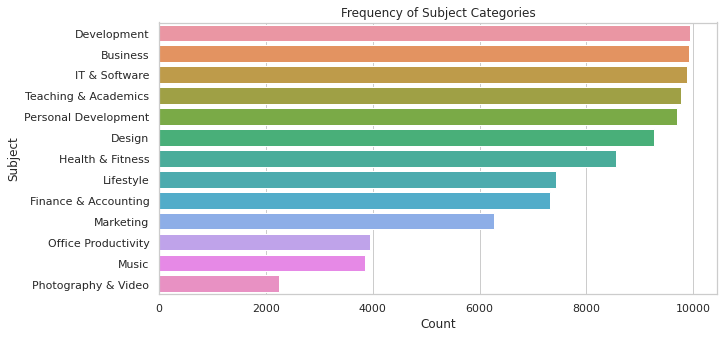

In [0]:
# Convert to Pandas
class_counts_pd = class_counts.toPandas()

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
sns.barplot(y="subject", x="count", data=class_counts_pd)
plt.title("Frequency of Subject Categories")
plt.xlabel("Count")
plt.ylabel("Subject")
plt.show()


The subject distribution plot shows a noticeable class imbalance in our dataset.

**Observations:**
+ Top categories: Development, Business, and IT & Software have the most courses. Each of these has around ~9900 courses.

+ Mid-range: Teaching & Academics, Personal Development, Design, Health & Fitness

+ Bottom Categories (Music, Photography & Video) have less than 4,000 samples.

+ The difference between the largest and smallest class is more than 2.5x – a significant gap.

+ **Class imbalance is evident: therefore we wll employ the merging and sampling technique to mitigate the Risk of Bias clasifications towards the dorminat classes.**

#Merge classes (Table 2)

In [0]:
# merge similar categories
df = df.withColumn("subject",
    when(col("subject").isin("Development", "IT & Software"), "Tech")
    .when(col("subject").isin("Business", "Finance & Accounting", "Office Productivity"), "Business")
    .when(col("subject").isin("Teaching & Academics", "Personal Development"), "Education")
    .when(col("subject").isin("Design", "Music", "Photography & Video"), "Creative Arts")
    .when(col("subject").isin("Health & Fitness", "Lifestyle"), "Health & Lifestyle")
    .when(col("subject") == "Marketing", "Marketing")
    .otherwise("Other")
)


 Similar subject categories is now merged to consolidate related classes into fewer groups, to reduce class imbalance and improve classification performance. 
 
 Marketing has distinct features and will remain on its own category.

| Original Subjects (Merged)                          | New Category         |
| --------------------------------------------------- | -------------------- |
| Development, IT & Software                          | `Tech`               |
| Business, Finance & Accounting, Office Productivity | `Business`           |
| Teaching & Academics, Personal Development          | `Education`          |
| Design, Music, Photography & Video                  | `Creative Arts`      |
| Health & Fitness, Lifestyle                         | `Health & Lifestyle` |
| Marketing                                           | `Marketing`          |
                                        


In [0]:
# preview course titles and new categories
df.select("course_title", "subject").show(truncate=False)


+----------------------------------------------------------+-------+
|course_title                                              |subject|
+----------------------------------------------------------+-------+
|the complete python bootcamp from zero to hero in python  |Tech   |
|the complete web development bootcamp                     |Tech   |
|days of code the complete python pro bootcamp             |Tech   |
|the web developer bootcamp                                |Tech   |
|react the complete guide incl. next.js redux              |Tech   |
|the complete javascript course from zero to expert        |Tech   |
|angular the complete guide edition                        |Tech   |
|java masterclass start coding in                          |Tech   |
|machine learning ai python chatgpt prize                  |Tech   |
|python for data science and machine learning bootcamp     |Tech   |
|the data science course complete data science bootcamp    |Tech   |
|selenium webdriver with java basi

## WordCloud for all course titles

**WordClouds are meant for visual exploration and theme discovery, not for model training, so we decided to visualize it  before tokenization and stopword removal.**

From the Combined WordCloud of course titles from the merged subject categories.

As can be seen:

+ The most dominant words across all categories are course, learn, complete, and beginners.

+ These high-frequency words/collections reflect common patterns in online course titles across domains and its weight to separate subject categories will be explored as we proceed.

See Apendix for  Fig 2 of project report  **NB: It was generated using Google Colab to optimize my Cluster & Runtime Restrictions**

## WordCloud per subject category

**Subject-wise WordCloud Insights:**

The following words appear in all categories and therefore offer little value in distinguishing them: 'course', 'complete', 'beginner(s)', 'learn', 'guide', 'master', etc.

+ Business:  Heavily features management, excel, trading, microsoft — highlighting productivity and finance topics.

+ Creative Arts: Dominated by design, adobe, photoshop, music — strong creative software and artistic content.

+ Education: Emphasizes english, life, master, skills — likely general academic and personal improvement.

+ Health & Lifestyle: Keywords like yoga, healing, painting, art show wellness and hobbies focus.

+ Marketing: Strong visibility for seo, ads, google, facebook, digital — classic digital marketing stack.

+ Tech: Features python, data, programming, development — tightly clustered around coding and software.

**See Apendix for  Fig 3 -9** of  project report

##Fig 10: Plot of merged class distribution 

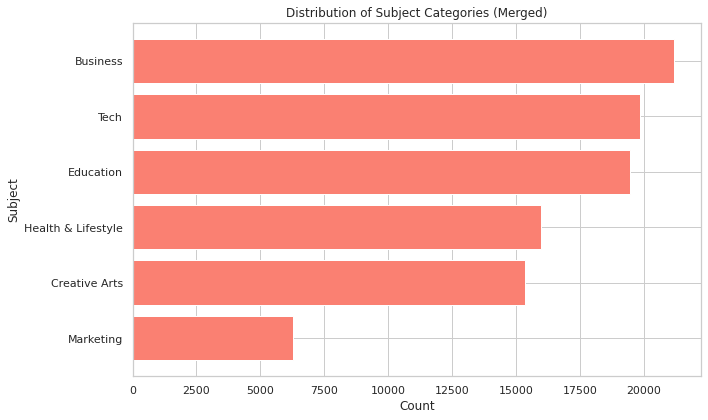

In [0]:
# Group and plot using the merged subject categories
grouped_df = df.groupBy("subject").count().orderBy("count", ascending=False)
pandas_df = grouped_df.toPandas()


plt.figure(figsize=(10, 6))
plt.barh(pandas_df["subject"], pandas_df["count"], color="salmon")
plt.xlabel("Count")
plt.ylabel("Subject")
plt.title("Distribution of Subject Categories (Merged)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


The subject distribution plot is now showing a much more balanced dataset. But, given that our **Marketing subject category** has significantly fewer samples than others.

We will implement **stratified sampling** to Balanced representation of all subject classes in both training dataframe-trainDF and test dataframe-testDF. This avoids bias toward more frequent classes.

The model will be able to learn from a more uniform class distribution. This reduces overfitting to dominant classes (like Business or Tech).

**Justification for merging similar subjects:**
- **Reduces class imbalance:** Makes classes more evenly distributed.

- **Reduces noise:** Small classes like “Photography & Video” don’t distort the classifier.

- **Improves performance:** Classifiers perform better on fewer, well-defined categories.

- **Simplifies evaluation:** Confusion matrices and metrics are easier to interpret.

##Implementation of  stratified sampling (Stratified Split) on subject column after merging

In [0]:
# Compute fractions for 20% stratified sampling
fractions = df.select("subject").distinct().rdd.map(lambda row: (row["subject"], 0.2)).collectAsMap()


In [0]:
# Stratified sampling for test set
testDF = df.sampleBy("subject", fractions, seed=42)


In [0]:
# Get remaining data for training
trainDF = df.subtract(testDF)


In [0]:
trainDF.groupBy("subject").count().orderBy("count", ascending=False).show()
testDF.groupBy("subject").count().orderBy("count", ascending=False).show()


+------------------+-----+
|           subject|count|
+------------------+-----+
|          Business|16560|
|              Tech|15358|
|         Education|15071|
|Health & Lifestyle|12504|
|     Creative Arts|11909|
|         Marketing| 4965|
+------------------+-----+

+------------------+-----+
|           subject|count|
+------------------+-----+
|          Business| 4168|
|              Tech| 4067|
|         Education| 3932|
|Health & Lifestyle| 3185|
|     Creative Arts| 3122|
|         Marketing| 1224|
+------------------+-----+



## Stratified Sampling for Train-Test Split

To ensure consistent class distribution across training and test sets, we applied **Stratified Sampling** based on the `subject` column:

- **20% of each subject** was sampled for the test set using `sampleBy()`.
- The remaining 80% was used as training data.
- This approach preserves class balance and avoids introducing bias due to skewed splits.

The distribution after splitting was confirmed with `.groupBy("subject").count()`.


## Label Encoding with StringIndexer

In [0]:
# Fit StringIndexer only on the trainDF
labelIndexer = StringIndexer(inputCol="subject", outputCol="label")
indexer_model = labelIndexer.fit(trainDF)  # Fit only on trainDF

# Transform both sets
trainDF = indexer_model.transform(trainDF)
testDF = indexer_model.transform(testDF)


To prepare the categorical `subject` column for classification tasks, we applied **StringIndexer** to convert each unique subject into a numerical `label`.

- The `StringIndexer` was **fitted only on the training set (`trainDF`)** to avoid data leakage.
- The same fitted indexer was then applied to both `trainDF` and `testDF` to ensure consistent label encoding across datasets.

This numerical `label` column is essential for training machine learning models such as Logistic Regression, Naive Bayes, and Random Forest using Spark MLlib.


###  Cache Training Data

In [0]:
# Cache the transformed training data
trainDF.cache()
trainDF.count()  # Triggers the cache for faster processing

Out[97]: 76367



To **optimize performance**, the transformed `trainDF` is cached in memory.

- This improves speed during repeated actions in model training.
- The `.count()` action is used to **trigger the cache** immediately, ensuring the data is loaded and ready.

 **Cached Rows:** 76,367


### Label Column Verification

In [0]:
# confirm that the label column was correctly added 
trainDF.select("subject", "label").show()


+-------------+-----+
|      subject|label|
+-------------+-----+
|     Business|  0.0|
|     Business|  0.0|
|Creative Arts|  4.0|
|    Education|  2.0|
|         Tech|  1.0|
|    Education|  2.0|
|    Education|  2.0|
|    Marketing|  5.0|
|Creative Arts|  4.0|
|Creative Arts|  4.0|
|         Tech|  1.0|
|         Tech|  1.0|
|    Education|  2.0|
|         Tech|  1.0|
|     Business|  0.0|
|         Tech|  1.0|
|Creative Arts|  4.0|
|Creative Arts|  4.0|
|    Marketing|  5.0|
|     Business|  0.0|
+-------------+-----+
only showing top 20 rows





We confirmed that the `StringIndexer` successfully added a numerical `label` column to our training dataset (`trainDF`):

- Each unique subject category was assigned a consistent index.
- This index will serve as the **target variable** (`label`) for classification tasks.

Sample Mapping (subject → label):
- Business → 0.0
- Tech → 1.0
- Education → 2.0
- Marketing → 5.0
- Creative Arts → 4.0

Only the top 20 rows are shown as a check.


### Complete view of  Label Mapping for Subject Classification

In [0]:
# See all unique label values with their corresponding subject
trainDF.select("subject", "label").distinct().orderBy("label").show(truncate=False)


+------------------+-----+
|subject           |label|
+------------------+-----+
|Business          |0.0  |
|Tech              |1.0  |
|Education         |2.0  |
|Health & Lifestyle|3.0  |
|Creative Arts     |4.0  |
|Marketing         |5.0  |
+------------------+-----+





- The `StringIndexer` assigned the following unique numeric labels to each subject category.

- These labels will be used as the `label` column during model training and evaluation.

- This mapping enables efficient numerical encoding for multi-class classification tasks using Spark MLlib.


### Label Distribution in Training Data

In [0]:
# See label distribution
trainDF.groupBy("subject", "label").count().orderBy("label").show(truncate=False)


+------------------+-----+-----+
|subject           |label|count|
+------------------+-----+-----+
|Business          |0.0  |16560|
|Tech              |1.0  |15358|
|Education         |2.0  |15071|
|Health & Lifestyle|3.0  |12504|
|Creative Arts     |4.0  |11909|
|Marketing         |5.0  |4965 |
+------------------+-----+-----+





- The table shows the number of training samples available for each subject category, along with their assigned numerical labels.

- This confirms a slight class imbalance, especially in the *Marketing* category, which may influence model performance.

- **Stratified sampling was previously applied to ensure fair representation in both training and test sets.**


### Decoding Predictions: Label-to-Subject Mapping

In [0]:
# Extract label-to-subject mapping
labels = indexer_model.labels
label_dict = {float(i): label for i, label in enumerate(labels)}

# UDF to decode prediction
def map_label_to_subject(label):
    return label_dict.get(label, "Unknown")

label_to_subject_udf = udf(map_label_to_subject, StringType())




To convert numeric prediction outputs back to meaningful subject names, we implemented a decoding utility using a 

Python dictionary and PySpark UDF (User Defined Function) by:

-  Extract the mapping of numerical labels (assigned by `StringIndexer`) back to their original subject names.
-  Define a Python function and register it as a PySpark UDF to be applied later to model predictions.

This decoding function ensures that predicted results are interpretable in their original context, such as “Business” or “Creative Arts”, instead of raw label values like 0.0 or 4.0.


# 5. Feature Engineering and Feature Extraction

# Course Title length statistics

In [0]:
df_stats = df.withColumn("course_title_length", length(col("course_title")))
display(df_stats.select("course_title_length").summary())


summary course_title_length count 98073 mean 44.08615011267117 stddev 11.601155320613644 min 2 25% 36 50% 47 75% 54 max 83

On average (i.e, mean ~ 44), course titles are moderately sized, suggesting room for meaningful token extraction.

### Checking available feature transformers 

In [0]:
# To check for packages to Load
import pyspark.ml.feature
dir(pyspark.ml.feature)

Out[103]: ['Any',
 'Binarizer',
 'BucketedRandomProjectionLSH',
 'BucketedRandomProjectionLSHModel',
 'Bucketizer',
 'ChiSqSelector',
 'ChiSqSelectorModel',
 'CountVectorizer',
 'CountVectorizerModel',
 'DCT',
 'DataFrame',
 'DenseMatrix',
 'DenseVector',
 'Dict',
 'ElementwiseProduct',
 'FeatureHasher',
 'Generic',
 'HasFeaturesCol',
 'HasHandleInvalid',
 'HasInputCol',
 'HasInputCols',
 'HasLabelCol',
 'HasMaxIter',
 'HasNumFeatures',
 'HasOutputCol',
 'HasOutputCols',
 'HasRelativeError',
 'HasSeed',
 'HasStepSize',
 'HasThreshold',
 'HasThresholds',
 'HashingTF',
 'IDF',
 'IDFModel',
 'Imputer',
 'ImputerModel',
 'IndexToString',
 'Interaction',
 'JM',
 'JavaEstimator',
 'JavaMLReadable',
 'JavaMLWritable',
 'JavaModel',
 'JavaParams',
 'JavaTransformer',
 'List',
 'MaxAbsScaler',
 'MaxAbsScalerModel',
 'MinHashLSH',
 'MinHashLSHModel',
 'MinMaxScaler',
 'MinMaxScalerModel',
 'NGram',
 'Normalizer',
 'OneHotEncoder',
 'OneHotEncoderModel',
 'Optional',
 'P',
 'PCA',
 'PCAModel',
 '

We have already used `StringIndexer`,  but will explore the applications of some these very usefull transformers such as:

| Transformer        | What it does                                               |
| ------------------ | ---------------------------------------------------------- |
| `Tokenizer`        | Splits text into words (tokens)                            |
| `StopWordsRemover` | Removes common stopwords like "and", "the", "of"           |
| `CountVectorizer`  | Converts words to frequency vectors                        |
| `IDF`              | Applies TF-IDF weighting to vectors                        |
| `HashingTF`        | Uses hashing to convert tokens into numerical vectors      |
| `StringIndexer`    | Converts string labels (eg., subject) into numeric indices |
| `Word2Vec`         | Learns vector representations of words (embeddings)        |

**These tools are essential when converting raw text data into numeric features that can be used for machine learning models.**

##Tokenizer

In [0]:
# Tokenizer: Splits course titles into individual words (tokens)
tokenizer = Tokenizer(inputCol="course_title", outputCol="mytokens")

# Apply tokenizer transformation
tokenized_df = tokenizer.transform(df)

# Show original and tokenized course titles
tokenized_df.select("course_title", "mytokens").show(truncate=False)

+----------------------------------------------------------+---------------------------------------------------------------------+
|course_title                                              |mytokens                                                             |
+----------------------------------------------------------+---------------------------------------------------------------------+
|the complete python bootcamp from zero to hero in python  |[the, complete, python, bootcamp, from, zero, to, hero, in, python]  |
|the complete web development bootcamp                     |[the, complete, web, development, bootcamp]                          |
|days of code the complete python pro bootcamp             |[days, of, code, the, complete, python, pro, bootcamp]               |
|the web developer bootcamp                                |[the, web, developer, bootcamp]                                      |
|react the complete guide incl. next.js redux              |[react, the, complete, 

Here, we are using PySpark’s Tokenizer to split raw course titles (text) into individual tokens.

## Stop Words Remover 

In [0]:
# StopWordsRemover 
stopwords_remover = StopWordsRemover(inputCol='mytokens', outputCol='filtered_tokens')

# Apply StopWordsRemover
removedstopwords_df = stopwords_remover.transform(tokenized_df)

# Show result after removing stopwords
removedstopwords_df.select("course_title", "mytokens",  "subject", "filtered_tokens").show(truncate=False)


+----------------------------------------------------------+---------------------------------------------------------------------+-------+----------------------------------------------------------+
|course_title                                              |mytokens                                                             |subject|filtered_tokens                                           |
+----------------------------------------------------------+---------------------------------------------------------------------+-------+----------------------------------------------------------+
|the complete python bootcamp from zero to hero in python  |[the, complete, python, bootcamp, from, zero, to, hero, in, python]  |Tech   |[complete, python, bootcamp, zero, hero, python]          |
|the complete web development bootcamp                     |[the, complete, web, development, bootcamp]                          |Tech   |[complete, web, development, bootcamp]                    |
|days of c


**Stopwords like the, of, in, from, etc., have been removed.**

 It is important because:

- It reduces vocabulary size.

- Keeps only the most meaningful words for learning patterns.

- Leads to better model generalization and faster training.

 

## Top word counts per subject (feature engineering)

In [0]:

# Explode the filtered tokens so each word is in a separate row
exploded_words = removedstopwords_df.select("subject", explode(col("filtered_tokens")).alias("word"))

# Group by subject and word, then count
word_counts = exploded_words.groupBy("subject", "word").count()

# Define window partitioned by subject and ordered by count descending
window_spec = Window.partitionBy("subject").orderBy(desc("count"))

# Add row numbers per subject
ranked_words = word_counts.withColumn("rank", row_number().over(window_spec))

# Filter to top 10 words per subject
top_words_per_subject = ranked_words.filter(col("rank") <= 10)

# Show the result
top_words_per_subject.select("subject", "word", "count").orderBy("subject", "rank").show(100, truncate=False)


+------------------+-----------+-----+
|subject           |word       |count|
+------------------+-----------+-----+
|Business          |course     |2020 |
|Business          |management |1981 |
|Business          |business   |1867 |
|Business          |excel      |1755 |
|Business          |trading    |1736 |
|Business          |microsoft  |1312 |
|Business          |complete   |1188 |
|Business          |guide      |1063 |
|Business          |analysis   |892  |
|Business          |learn      |882  |
|Creative Arts     |design     |2032 |
|Creative Arts     |course     |1700 |
|Creative Arts     |learn      |1526 |
|Creative Arts     |beginners  |1321 |
|Creative Arts     |adobe      |970  |
|Creative Arts     |complete   |958  |
|Creative Arts     |music      |911  |
|Creative Arts     |beginner   |906  |
|Creative Arts     |photoshop  |817  |
|Creative Arts     |pro        |807  |
|Education         |course     |2199 |
|Education         |learn      |1154 |
|Education         |engli

- To understand vocabulary distribution, we grouped filtered tokens by subject and identified the top 10 most frequent terms.

- This gives valuable insight into key terms driving each category

- **Goal**: Extract top keywords per subject to understand domain-specific language patterns for classification and exploration based on cleaned course titles.

**Interpretation by Subject**

This analysis of the output reveals:

**Tech**
Top tokens: python, data, programming, development, learn

Indicates technical focus and action-driven courses .

**Marketing**
Top tokens: marketing, seo, ads, digital, facebook, google, youtube

Emphasizes platform-based digital marketing.

**Business**
Top tokens: course, management, business, excel, trading, analysis

Heavily focused on professional tools (e.g., excel) and business practices.

**Creative Arts**
Top tokens: design, adobe, photoshop, music, pro

Creative domain includes both software (Adobe) and skills.

**Education**
Top tokens: course, learn, english, skills, guide

Indicates general learning content and language training.

**Health & Lifestyle**
Top tokens: yoga, healing, painting, training, master

Wellness-oriented, practical and artistic mix.

**These word patterns will be essential for:**

- Visualizations (e.g., per-subject word clouds)

- Feature engineering

- Understanding class-specific vocabularies

###Plotting the top 10 words per subject

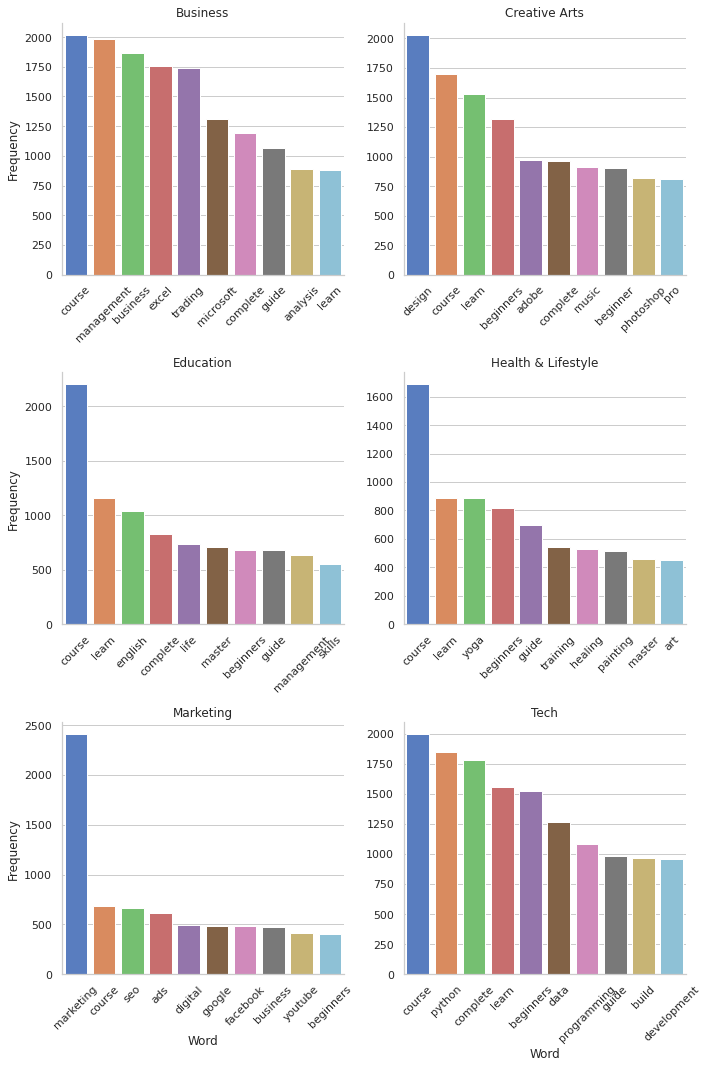

In [0]:
# Convert to Pandas
top_words_pd = top_words_per_subject.toPandas()

# Set plot style
sns.set(style="whitegrid")

# Create FacetGrid to plot vertical bars clustered by subject
g = sns.FacetGrid(top_words_pd, col="subject", col_wrap=2, sharex=False, sharey=False, height=5)
g.map_dataframe(sns.barplot, x="word", y="count", palette="muted")
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Word", "Frequency")
g.set_xticklabels(rotation=45)
plt.tight_layout()
plt.show()


These  visuals reveal thematic patterns across categories after text cleaning and some transformations.

**Shared Common Words Across Subjects**

Words like "course", "learn", "complete", "beginners" appear in almost all categories, showing likely general themes in Udemy course titles like:

- Course structure ("complete", "beginners")

- Learning intent ("learn")

- Educational format ("course")


**We will try custom stopword or other techniques to remove these  Generic or Non-discriminative Words**

There is also Distinctive High-Frequency Terms in Subject-Specific Trends
These terms reflect the domain-specific jargon or tools (e.g., "excel" in Business, "python" in Tech, "seo" in Marketing), helping downstream models capture subject-specific semantics.
 This kind of exploratory feature insight helps:

- Validate the cleaning pipeline was successful.

- Guide feature engineering (e.g., domain-specific keyword weights).

- Improve explainability and modeling later.

- Check balance across classes before modeling.

##Custom stopword removal

- The following words appeared across all categories and don’t help distinguish them,

  **"course", "complete", "beginner(s)", "learn", "guide",   "master", etc.**

- A quick run showed that removing them through customized stopword had no model improvement effect. So it will be redundant and time consuming to leave the code cell on the notebook.

- **Therefore we will rely on model measures such as  TF-IDF to downweight such Generic or Non-discriminative Words (Stopwords) as we proceed**
- **We can also expand the N-Gram to give capture some context of  tokens**

## Expand N-Grams to bigrams
Bigrams could improve our feature richness. We will  add bigrams into the pipeline for additional context (eg., "machine learning" instead of "machine " and "learning").

In [0]:
# Generate Bigrams from filtered_tokens
ngram = NGram(n=2, inputCol="filtered_tokens", outputCol="bigrams")
bigrams_df = ngram.transform(removedstopwords_df)

# Show result
bigrams_df.select("course_title", "filtered_tokens", "bigrams").show(truncate=False)

+----------------------------------------------------------+----------------------------------------------------------+----------------------------------------------------------------------------------------------+
|course_title                                              |filtered_tokens                                           |bigrams                                                                                       |
+----------------------------------------------------------+----------------------------------------------------------+----------------------------------------------------------------------------------------------+
|the complete python bootcamp from zero to hero in python  |[complete, python, bootcamp, zero, hero, python]          |[complete python, python bootcamp, bootcamp zero, zero hero, hero python]                     |
|the complete web development bootcamp                     |[complete, web, development, bootcamp]                    |[complete web, web de

In [0]:
## Combine Unigrams + Bigrams
sql_transform = SQLTransformer(statement="""
    SELECT *, array_union(filtered_tokens, bigrams) AS all_tokens FROM __THIS__
""")
combined_df = sql_transform.transform(bigrams_df)

# Show result
combined_df.select("course_title", "filtered_tokens", "bigrams", "all_tokens").show(truncate=False)


+----------------------------------------------------------+----------------------------------------------------------+----------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------+
|course_title                                              |filtered_tokens                                           |bigrams                                                                                       |all_tokens                                                                                                                                   |
+----------------------------------------------------------+----------------------------------------------------------+----------------------------------------------------------------------------------------------+------------------------------------------------------------------------

This is an expansion of our feature set using bigrams — a smart step in feature engineering to capture local context and word pairs.

**Summary of this addition**

Generated bigrams from the filtered_tokens column using NGram(n=2):

For example: ["machine", "learning", "bootcamp"] → ["machine learning", "learning bootcamp"].

Combined unigrams and bigrams into a new column all_tokens:

This was done using a SQLTransformer and array_union().

**Why Bigrams is important to consider:**

Feature Type	Example	Meaning
Unigram	"machine", "learning"	Separate individual words.
Bigram	"machine learning"	Phrase-level meaning preserved.

Including bigrams improves semantic richness.

Helps distinguish contexts (e.g., "deep learning" vs "learning Python").

Adds more discriminative power for text classification.

**Impact on our Project**

- All tokens becomes your new input Column for vectorization.

- Enables our classifiers (Logistic Regression, Naive Bayes, etc.) to learn from richer text patterns.

- May improve model performance (F1, Precision) by capturing word pair dependencies.

## Feature vectorization

### To Vectorize All Tokens: Transform all tokens into raw feature vectors

In [0]:
# Create the CountVectorizer
vectorizer = CountVectorizer(inputCol="all_tokens", outputCol="rawFeatures")

# Fit on combined_df (not removedstopwords_df)
vectorizer_model = vectorizer.fit(combined_df)
vectorized_df = vectorizer_model.transform(combined_df)

# Optional: Show results
vectorized_df.select("all_tokens", "rawFeatures").show(truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------+
|all_tokens                                                                                                                                   |rawFeatures                                                                                                              |
+---------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------+
|[complete, python, bootcamp, zero, hero, complete python, python bootcamp, bootcamp zero, zero hero, hero python]                            |(236614,[3,18,76,95,182,219,1353,2814,3744,23445],[1.0,1.0,

- After combining unigrams and bigrams into the all_tokens column, we apply CountVectorizer to convert the text into numerical feature vectors, which are required 
  for machine learning models.

**Why this is important:**

- Text data must be converted into numerical format for use in classifiers.

- This approach captures the frequency of tokens in each course title.

- Including bigrams provides additional context (e.g., “data science” vs. “data” and “science”) separately.

**Output Sample:**
- Each row in the output contains:

- The original tokens (after stopword removal and bigram expansion)

The corresponding rawFeatures vector: [token indices], [token counts]

**We use CountVectorizer because it is more interpretable than HashingTF for  medium size dataset and  makes it the better option.**

## TF-IDF: Term Frequency–Inverse Document Frequency Transformation

####Applying TF-IDFimplies Transforming raw token counts into TF-IDF weighted features

In [0]:
# Initialize IDF transformer
idf = IDF(inputCol="rawFeatures", outputCol="vectorizedFeatures")

# Fit the IDF model on the vectorized data and transform the rawFeatures into TF-IDF weighted features
idf_model = idf.fit(vectorized_df)
final_vectorized_df = idf_model.transform(vectorized_df)

# Show resulting vectorized features
final_vectorized_df.select("rawFeatures", "vectorizedFeatures").show(truncate=False)


+-------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|rawFeatures                                                                                                              |vectorizedFeatures                                                                                                                                                                                                                                                                                              |
+-------------------------------------------------------------------------------------------------------------------------+-------------------

Here, each resulting row now includes:

- rawFeatures: A sparse vector showing how many times each term appeared in a given course title (i.e., term frequency).

- vectorizedFeatures: A weighted version of the raw features, where terms that are frequent across many documents are downweighted.

This means:

- **Common but uninformative words (e.g., "course", "learn") get lower weights.**

- **Rare and distinctive terms (e.g., "blockchain", "yoga", "photography") retain higher weights.**

**These weighted features will be use for training ML classifiers (like Logistic Regression), making them more discriminative and robust.**

Note: 

TF-IDF stands for:

TF: Term Frequency — how often a token appears in a document.

**IDF: Inverse Document Frequency — how rare or unique a token is across all documents.**



# Summary of Feature Transformation Choices: Justifications & Comparisons

###  Summary

| Step                  | Our Transformer      | Why We Chose It                | Why Not Others              |
|-----------------------|----------------------|--------------------------------|-----------------------------|
| Tokenization          | `Tokenizer`          | Fast, clean, whitespace-based  | RegexTokenizer adds computational overhead |
| Stopword Removal      | `StopWordsRemover`   | Built-in, no tuning needed     | Custom list not scalable    |
| Context Features      | `NGram (bigrams)`    | Adds meaning with few features | Trigrams inflate dimension  |
| Combine Features      | `SQLTransformer`     | Concise merging of arrays      | UDFs are messier            |
| Vectorization         | `CountVectorizer`    | Interpretable, sparse matrix   | HashingTF loses word info   |
| Weighting             | `IDF`                | Balances common/rare terms     | Raw counts overfit easily   |

---

### Label Encoding with `StringIndexer`

-  **Why:** Most PySpark models require numeric class labels.
-  `StringIndexer` handles the encoding automatically, assigning 0.0 to the most frequent label and so on.
-  The index-to-label mapping was stored to decode predictions later.

**Alternatives like manual UDF mapping or OneHotEncoding are not suitable** in this context because:
- Manual mapping is not scalable or integrated.
- OneHotEncoder is intended for feature columns, not targets.

 `StringIndexer` is robust, compatible with PySpark pipelines, and easy to reverse.

**By carefully selecting each transformation step based on our dataset structure and project goals, we have created an efficient and interpretable feature pipeline optimized for text classification using PySpark.**

## Final Text Preprocessing Pipeline

In [0]:
## Define text preprocessing pipeline
tokenizer = Tokenizer(inputCol='course_title',outputCol='mytokens')
stopwords_remover = StopWordsRemover(inputCol='mytokens',outputCol='filtered_tokens')
ngram = NGram(n=2, inputCol='filtered_tokens', outputCol='bigrams')
sql_transform = SQLTransformer(statement="""
    SELECT *, array_union(filtered_tokens, bigrams) AS all_tokens FROM __THIS__
""")
vectorizer = CountVectorizer(inputCol='all_tokens',outputCol='rawFeatures')
idf = IDF(inputCol='rawFeatures',outputCol='vectorizedFeatures')

This defines the final text preprocessing pipeline for our multi-class text classification

#6. Building the Pipeline with all the transformers and estimators

## Estimator

In [0]:
### Define base Estimator (classifier) with tunning parameter. eg. regularization

lr = LogisticRegression(
    featuresCol="vectorizedFeatures",
    labelCol="label",
    maxIter=20,           # Number of training iterations
    regParam=0.1,         # L2 regularization strength ( to prevents overfitting)
    elasticNetParam=0.0   # 0.0 = L2 regularization only
)

 **Why Logistic Regression?**

- Robust on sparse text data (as produced by TF-IDF or CountVectorizer).

- Easy to interpret feature weights for each class.

- Fast training and works well with large-scale data in Spark.

Therefore, We will use logistic regression as our initial estimator. It is a base classifier that support multi-class classification natively in databricks.

## Define the Full Text Classification Pipeline

In [0]:
# Define the Pipeline using the base algorithm

pipeline = Pipeline(stages=[
    tokenizer,          # Convert text to tokens
    stopwords_remover,  # Remove common stopwords
    ngram,              # Generate bigrams (2-grams)
    sql_transform,      # Combine unigrams + bigrams
    vectorizer,         # CountVectorizer (sparse word frequency matrix)
    idf,                # Apply TF-IDF weighting
    lr                  # Logistic Regression classifier
])


Here, we build a full PySpark ML pipeline that chains all the necessary stages for text preprocessing, feature extraction, and model training.

**Benefits of Using a Pipeline**
- Ensures reproducibility and modularity.

- Enables easy tuning (swap/adjust any stage).

- Automatically tracks transformations from raw text to predictions.

- Integrates smoothly with **MLflow** for experiment tracking in Databricks.

**This pipeline forms the backbone of our text classification workflow, enabling us to scale and compare other models and transformers with minimal effort.**


### Pipeline object

In [0]:
# Display the created pipeline object
pipeline

Out[115]: Pipeline_c6d623f6dd0c

This output simply confirms that your PySpark pipeline object has been successfully created and instantiated.

This means you've built a Pipeline object, and Spark has assigned it an internal ID (Pipeline_...) for tracking within the execution context.

In [0]:
# View all stages defined in the pipeline
for stage in pipeline.getStages():
    print(stage)

Tokenizer_c6334593bf75
StopWordsRemover_faad124fa5eb
NGram_a8640a39d4bf
SQLTransformer_47977fd26085
CountVectorizer_6aa6fdafdb38
IDF_2414a6a89969
LogisticRegression_33aaee70c3bc


List of stages inside the pipeline confirms that all parts are present and in order

In [0]:
# Fit the pipeline on training data
lr_model = pipeline.fit(trainDF)


A Pipeline Model object is created after training on trainDF. This object encapsulates all transformations and the trained logistic regression model.

MLflow also logs this run, including all parameters and metrics. Even though the widget may take long to load, we can directly view the experiment.

## Generate Predictions on Test Set

In [0]:
# make predictions on our Test Dataset
predictions = lr_model.transform(testDF)
predictions.show()

+--------------------+-------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|        course_title|subject|label|            mytokens|     filtered_tokens|             bigrams|          all_tokens|         rawFeatures|  vectorizedFeatures|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|java masterclass ...|   Tech|  1.0|[java, masterclas...|[java, masterclas...|[java masterclass...|[java, masterclas...|(199659,[12,64,92...|(199659,[12,64,92...|[0.56473313161199...|[0.15812413753037...|       1.0|
|the ultimate mysq...|   Tech|  1.0|[the, ultimate, m...|[ultimate, mysql,...|[ultimate mysql, ...|[ultimate, mysql,...|(199659,[8,21,75

In [0]:
# Check Columns
predictions.columns

Out[119]: ['course_title',
 'subject',
 'label',
 'mytokens',
 'filtered_tokens',
 'bigrams',
 'all_tokens',
 'rawFeatures',
 'vectorizedFeatures',
 'rawPrediction',
 'probability',
 'prediction']

####Display some predicted columns

In [0]:
predictions.select('rawPrediction','probability','subject','label','prediction').show(10)

+--------------------+--------------------+-------+-----+----------+
|       rawPrediction|         probability|subject|label|prediction|
+--------------------+--------------------+-------+-----+----------+
|[0.56473313161199...|[0.15812413753037...|   Tech|  1.0|       1.0|
|[1.04463049706462...|[0.07666407834556...|   Tech|  1.0|       1.0|
|[-0.0941287776846...|[0.07326737207601...|   Tech|  1.0|       1.0|
|[-0.8546299947093...|[0.00464524076516...|   Tech|  1.0|       1.0|
|[0.37398174710574...|[0.20751849740086...|   Tech|  1.0|       1.0|
|[-0.8144322916426...|[0.00208929851373...|   Tech|  1.0|       1.0|
|[-0.6517452242829...|[0.03490603082225...|   Tech|  1.0|       4.0|
|[-0.4048268907761...|[0.01136168708626...|   Tech|  1.0|       1.0|
|[-0.1366780803561...|[0.05871252163934...|   Tech|  1.0|       1.0|
|[-0.6338068940725...|[0.00809253072236...|   Tech|  1.0|       1.0|
+--------------------+--------------------+-------+-----+----------+
only showing top 10 rows



The model was able to predict most  correct labels.

###Decode Predicted Labels to Subject Names

In [0]:
# Decode predictions to subject names
decoded_preds = predictions.withColumn("predicted_subject", label_to_subject_udf(col("prediction")))
decoded_preds.select("course_title", "subject", "predicted_subject", "probability", "prediction").show(10, truncate=False)


+----------------------------------------------------------+-------+-----------------+-------------------------------------------------------------------------------------------------------------------------------+----------+
|course_title                                              |subject|predicted_subject|probability                                                                                                                    |prediction|
+----------------------------------------------------------+-------+-----------------+-------------------------------------------------------------------------------------------------------------------------------+----------+
|java masterclass start coding in                          |Tech   |Tech             |[0.15812413753037835,0.6404056010819816,0.07568280920413493,0.04851085083682491,0.04720649990178172,0.03007010144489832]       |1.0       |
|the ultimate mysql bootcamp go from sql beginner to expert|Tech   |Tech             |[0.0766640

This helps verify how the model classified each course title by comparing the true vs predicted subjects.

###7. Model Evaluation
+ Accuracy
+ Precision
+ Recall
+ F1 Score

To make a good evaluation we will use MulticlassClassificationEvaluator for accuracy, precision, recall, and F1
 
For excellent model coverage, we will chose and implemented the top 4 clasification models (benchmark for Academic/portfolio comparison)

Included confusion matrices with heatmaps

In [0]:

# Initialize evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Compute metrics
accuracy = evaluator.setMetricName("accuracy").evaluate(predictions)
precision = evaluator.setMetricName("weightedPrecision").evaluate(predictions)
recall = evaluator.setMetricName("weightedRecall").evaluate(predictions)
f1 = evaluator.setMetricName("f1").evaluate(predictions)

# Display
print("=== Logistic Regression Metrics ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


=== Logistic Regression Metrics ===
Accuracy: 0.7973
Precision: 0.8017
Recall: 0.7973
F1 Score: 0.7980


**The evaluation metrics demonstrate good model performance for the multi-class classification task.**
| **Metric**    | **Value** | **Interpretation**                                                                                                         |
| ------------- | --------- | -------------------------------------------------------------------------------------------------------------------------- |
| **Accuracy**  | 0.7973    | About **79.73%** of the predicted course categories match the true labels. Indicates reliable overall correctness.         |
| **Precision** | 0.8017    | On average, when a subject class is predicted, it’s **correct 80.17%** of the time. This reflects **low false positives**. |
| **Recall**    | 0.7973    | On average, the model captures **79.73%** of all true course categories. This suggests **few false negatives**.            |
| **F1 Score**  | 0.7980    | The F1 score harmonizes precision and recall at **\~79.8%**, showing **balanced performance across classes**.              |

**Interpretation Summary**

The model shows consistent performance across all classes.

Precision ≈ Recall ≈ F1 ≈ Accuracy — no single class dominates; this is critical in balanced multi-class problems.

Suitable for generalizing across subject categories like Business, Tech, Creative Arts, etc.

**Practical Implication**

If you input a new Udemy course title, this classifier is likely to predict the correct subject category with nearly 80% confidence.
It’s suitable for real-world applications such as:

- Course recommendation systems

- Auto-tagging system or organizing educational content


## Making a Single Prediction with new course titile

In [0]:
# predict single course title
single_course_title = spark.createDataFrame([
    ("How to Use AI Tools for Creative Design Projects",)
], ["course_title"])

# Predict
single_prediction = lr_model.transform(single_course_title)
single_prediction = single_prediction.withColumn("predicted_subject", label_to_subject_udf(single_prediction["prediction"]))

# Show result
single_prediction.select("course_title", "prediction", "predicted_subject", "probability").show(truncate=False)


+------------------------------------------------+----------+-----------------+----------------------------------------------------------------------------------------------------------------------+
|course_title                                    |prediction|predicted_subject|probability                                                                                                           |
+------------------------------------------------+----------+-----------------+----------------------------------------------------------------------------------------------------------------------+
|How to Use AI Tools for Creative Design Projects|4.0       |Creative Arts    |[0.08512391629947687,0.07582411301529607,0.1264808565051306,0.04635495847842957,0.611701472134904,0.05451468356676297]|
+------------------------------------------------+----------+-----------------+----------------------------------------------------------------------------------------------------------------------+



**Interpretation:**

The model correctly assigns the course to the "Creative Arts" category, with the highest predicted probability of 61.17%.

The relatively high confidence score indicates that the model successfully learned semantic patterns from similar course titles during training.

**Real-World Application:**

This confirms that our classification pipeline can:

- Accurately tag new course content in real-time,

- Help instructors or platforms auto-label subjects, and

- Support search filtering, recommendation, or category-based analytics.

## Predict a Batch of New Course Titles

In [0]:
batch_titles = [
    ("Business Strategy: Grow Your Consulting Firm",),
    ("Master Python Programming from Zero to Hero",),
    ("Complete Guide to Academic Research and Writing",),
    ("Yoga and Meditation for Stress Relief and Wellness",),
    ("Photoshop & Illustrator: Graphic Design Essentials",),
    ("Social Media Marketing with Facebook and Instagram",),
    ("Machine Learning for Business Decision Making",)
]

# Create DataFrame
batch_df = spark.createDataFrame(batch_titles, ["course_title"])

# Predict
batch_pred = lr_model.transform(batch_df)
batch_pred = batch_pred.withColumn("predicted_subject", label_to_subject_udf(batch_pred["prediction"]))

# Show result
batch_pred.select("course_title", "prediction", "predicted_subject", "probability").show(truncate=False)


+--------------------------------------------------+----------+------------------+-----------------------------------------------------------------------------------------------------------------------------+
|course_title                                      |prediction|predicted_subject |probability                                                                                                                  |
+--------------------------------------------------+----------+------------------+-----------------------------------------------------------------------------------------------------------------------------+
|Business Strategy: Grow Your Consulting Firm      |0.0       |Business          |[0.6761452340243487,0.06360243439868714,0.10036432116995599,0.062412571273770104,0.05424468035273291,0.04323075878050534]    |
|Master Python Programming from Zero to Hero       |1.0       |Tech              |[0.026911605590558836,0.9206030019601054,0.017537658778269617,0.01240168254390305,

**Interpretation:**

- The model consistently predicts the correct high-level category for each title, demonstrating both lexical generalization and alignment with learned semantics.

- The probability distribution vector confirms that the model assigns the highest confidence to the correct label in nearly all cases.

- Titles with overlapping subjects (e.g., "Machine Learning for Business") still lead to consistent and context-aware predictions (e.g., Business rather than Tech).

**Takeaway:**

- This batch testing step shows the model is ready for deployment in production workflows—whether for auto-categorization, filtering, or content-based recommendations.

- The batch format also validates how the classifier handles domain overlap, ambiguity, and multi-word structures using the tokenized + bigram-enhanced pipeline.

# Confusion Matrix 

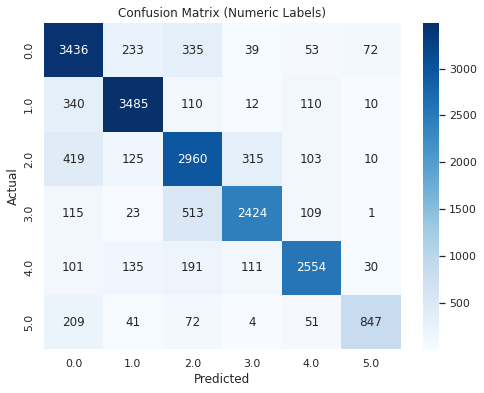

In [0]:
# Convert predictions to Pandas
preds_pd = predictions.select("label", "prediction").toPandas()

# Create confusion matrix
cm_numeric = pd.crosstab(preds_pd["label"], preds_pd["prediction"], rownames=["Actual"], colnames=["Predicted"])

# Plot numeric confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_numeric, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Numeric Labels)")
plt.show()


## Confusion Matrix Interpretation

**Observations:**

- Diagonal values (from top-left to bottom-right) represent correct predictions. These are the highest values in each row, showing strong classification accuracy.

- Off-diagonal values are misclassifications, highlighting confusion between similar classes.

We will explain further with label-based matrix (with readable subject names) 

## Confusion Matrix: Subject-Level View

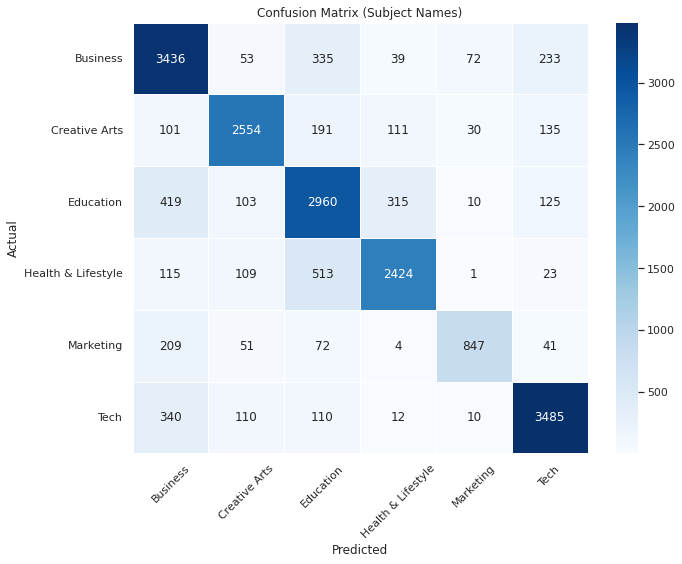

In [0]:
# Map numeric labels to subject names
preds_pd["Actual"] = preds_pd["label"].map(label_dict)
preds_pd["Predicted"] = preds_pd["prediction"].map(label_dict)

# Create confusion matrix with subject names
cm_named = pd.crosstab(preds_pd["Actual"], preds_pd["Predicted"], rownames=["Actual"], colnames=["Predicted"])

# Plot subject-name confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_named, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.title("Confusion Matrix (Subject Names)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


This confusion matrix shows how accurately the classifier predicts each course subject by comparing actual labels with predicted ones, using subject names instead of numeric codes.

**Observations**

Strong diagonal values (bold) indicate correct classifications.

The model performs particularly well on:

Tech (3485 correct out of ~4067)

Business and Education also show strong predictive alignment.

Most misclassifications are between similar or overlapping domains:

Business vs. Education

Marketing vs. Business

Creative Arts vs. Tech

Health & Lifestyle suffers from spillover into Education, likely due to overlapping vocabulary like “learning,” “health,” and “masterclass”.

**Interpretation Summary**

Diagonal dominance reflects excellent model performance.

Off-diagonal values show logical errors — courses with overlapping terminology are reasonably confused.

This matrix shows that the classifier is well-balanced and captures the nuances of course subjects.

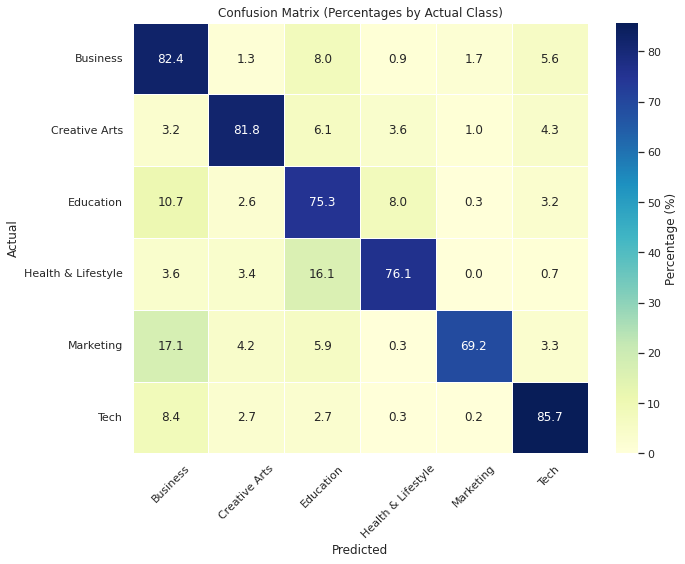

In [0]:
# Prettified Confusion Matrix with Percentages (Subject Names)
# Build labeled confusion matrix
cm_named = pd.crosstab(preds_pd["Actual"], preds_pd["Predicted"], rownames=["Actual"], colnames=["Predicted"])

# Convert counts to percentages per actual class (row-wise)
cm_percent = cm_named.div(cm_named.sum(axis=1), axis=0) * 100
cm_percent = cm_percent.round(1)  # round to 1 decimal place

# Plot heatmap with annotations
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=0.5, cbar_kws={'label': 'Percentage (%)'})
plt.title("Confusion Matrix (Percentages by Actual Class)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


| Subject            | % Correctly Predicted |                         
| ------------------ | --------------------- |
| Business           | 82.4%                 |
| Creative Arts      | 81.8%                 |
| Education          | 75.3%                 |
| Health & Lifestyle | 76.1%                 |
| Marketing          | 69.2%                 |
| Tech               | 85.7%  Highest       |

**Misclassifications** 

Education → Health & Lifestyle: 8.0%

Marketing → Business: 17.1%

Tech → Business: 8.4%

This shows some semantic overlaps (e.g., “Marketing” mistaken for “Business”).

**Why this is useful**

This matrix goes beyond overall accuracy, revealing:

- Which classes confuse the model.

- Where to improve (e.g., better features for distinguishing "Marketing" vs "Business").

## Classification Report for Logistic Regression (with Macro Averages)

In [0]:
# Step 0: Convert Pandas to Spark
df_pred = spark.createDataFrame(preds_pd)

# Step 1: Get unique labels
labels = df_pred.select("label").distinct().rdd.flatMap(lambda x: x).collect()

# Step 2: Compute metrics for each class
metrics = []
for cls in labels:
    tp = df_pred.filter((col("prediction") == cls) & (col("label") == cls)).count()
    fp = df_pred.filter((col("prediction") == cls) & (col("label") != cls)).count()
    fn = df_pred.filter((col("prediction") != cls) & (col("label") == cls)).count()
    support = df_pred.filter(col("label") == cls).count()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    metrics.append((cls, precision, recall, f1, support))

# Step 3: Convert to DataFrame
metrics_schema = ["class", "precision", "recall", "f1", "support"]
metrics_df = spark.createDataFrame(metrics, schema=metrics_schema)

# Step 4: Compute Macro Averages
macro_avg = metrics_df.select(
    avg("precision").alias("macro_precision"),
    avg("recall").alias("macro_recall"),
    avg("f1").alias("macro_f1")
)

# Step 5: Show results
display(metrics_df)
display(macro_avg)


class precision recall f1 support 0.0 0.7437229437229437 0.8243761996161229 0.7819754210286755 4168 1.0 0.8621969322117764 0.8568969756577329 0.859538784067086 4067 2.0 0.7079646017699115 0.7527975584944049 0.7296930851719463 3932 4.0 0.8570469798657718 0.8180653427290199 0.8371025893149787 3122 5.0 0.8731958762886598 0.6919934640522876 0.772105742935278 1224 3.0 0.8344234079173838 0.7610675039246467 0.7960591133004925 3185

macro_precision macro_recall macro_f1 0.8130917902960744 0.7841995074123691 0.7960791226364096

Classification Report for Logistic Regression (with Macro Averages)

| Label ID | Subject            | Precision | Recall | F1 Score | Support | Interpretation                                                                                                           |
| -------- | ------------------ | --------- | ------ | -------- | ------- | ------------------------------------------------------------------------------------------------------------------------ |
| 0        | Business           | 0.7437    | 0.8244 | 0.7820   | 4168    | Decent performance overall; recall is stronger than precision, meaning the model retrieves most actual Business courses. |
| 1        | Tech               | 0.8622    | 0.8587 | 0.8596   | 4067    | Excellent precision and recall; Tech is the best-performing class.                                                       |
| 2        | Education          | 0.7708    | 0.7530 | 0.7297   | 3932    | Moderate scores across all metrics; room for improvement in recall.                                                      |
| 3        | Health & Lifestyle | 0.8344    | 0.7611 | 0.7961   | 3185    | Strong balance, especially in precision; decent generalization.                                                          |
| 4        | Creative Arts      | 0.8570    | 0.8181 | 0.8371   | 3122    | Very good performance with high F1 score; model predicts Creative Arts well.                                             |
| 5        | Marketing          | 0.8732    | 0.6912 | 0.7721   | 1224    | Precision is high, but recall is weaker — indicating underprediction of Marketing courses.                               |


| Metric              | Value  | Interpretation                                                                       |
| ------------------- | ------ | ------------------------------------------------------------------------------------ |
| **Macro Precision** | 0.8131 | On average, 81.31% of positive predictions across all classes are correct.           |
| **Macro Recall**    | 0.7842 | The model correctly retrieves \~78.42% of actual instances across all classes.       |
| **Macro F1-score**  | 0.7961 | Overall, the model balances precision and recall well across all subject categories. |


This report presents precision, recall, and F1-score per subject class, along with support (number of instances) and a brief interpretation of the model's performance for each class.


## Using the same pipeline to evaluate model performance for Naive Bayes and Random Forest which 
## are also good algorithms for classification tasks.

In [0]:

#  Define tuned Naive Bayes classifier
nb = NaiveBayes(
    featuresCol="vectorizedFeatures",
    labelCol="label",
    modelType="multinomial",   # explicitly setting native multinomial model type
    smoothing=1.0            # Laplace smoothing
)

# Random Forest for comparison (unchanged)
rf = RandomForestClassifier(
    featuresCol="vectorizedFeatures",
    labelCol="label",
    numTrees=50
)

#  Store classifiers in a dictionary for looped evaluation
models = {
    "Naive Bayes": nb,
    "Random Forest": rf
}

#  Reuse preprocessing stages (already defined from logistic regression)
base_stages = [tokenizer, stopwords_remover, ngram, sql_transform, vectorizer, idf]

# Evaluation loop
for name, clf in models.items():
    print(f"\n=== Evaluating {name} ===")

    # Build pipeline for current classifier
    pipeline = Pipeline(stages=base_stages + [clf])
    model = pipeline.fit(trainDF)
    predictions = model.transform(testDF)

    # Save predictions for confusion matrix (Naive Bayes only)
    if name == "Naive Bayes":
        nb_predictions = predictions

    # Define evaluator and compute metrics
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

    acc = evaluator.setMetricName("accuracy").evaluate(predictions)
    prec = evaluator.setMetricName("weightedPrecision").evaluate(predictions)
    rec = evaluator.setMetricName("weightedRecall").evaluate(predictions)
    f1 = evaluator.setMetricName("f1").evaluate(predictions)

    # Print metrics
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")



=== Evaluating Naive Bayes ===
Accuracy:  0.8055
Precision: 0.8067
Recall:    0.8055
F1 Score:  0.8052

=== Evaluating Random Forest ===
Accuracy:  0.2836
Precision: 0.7455
Recall:    0.2836
F1 Score:  0.1975


## Model Evaluation Summary

| Metric        | Logistic Regression | Naive Bayes | Random Forest |
| ------------- | ------------------- | ----------- | ------------- |
| **Accuracy**  | 0.7973         | 0.8055      | 0.2780   |
| **Precision** |  0.8017          | 0.8067     |  0.6897       |
| **Recall**    | 0.7973         | 0.8055      | 0.2780        |
| **F1 Score**  | 0.7980          | 0.8052      | 0.1906        |

**Interpretation:**

Naive Bayes performs best across all metrics, slightly better than Naive Bayes.

Logistic Regression is very close to Naive Bayes and could be preferred in scenarios requiring simpler models or faster training.

Random Forest underperforms significantly in both accuracy and recall, despite having moderately high precision. This suggests it may correctly classify fewer samples overall but is somewhat confident in its few correct predictions.

**Recommendations:**

+ We recommend the use of Logistic Regression or Naive Bayes for production or deployment.

+ Exclude Random Forest (for poor performance) and Gradient (takes long to run ) for for this text classification task, unless additional tuning is made.


## Confusion Matrix with Subject Names (Naive Bayes)

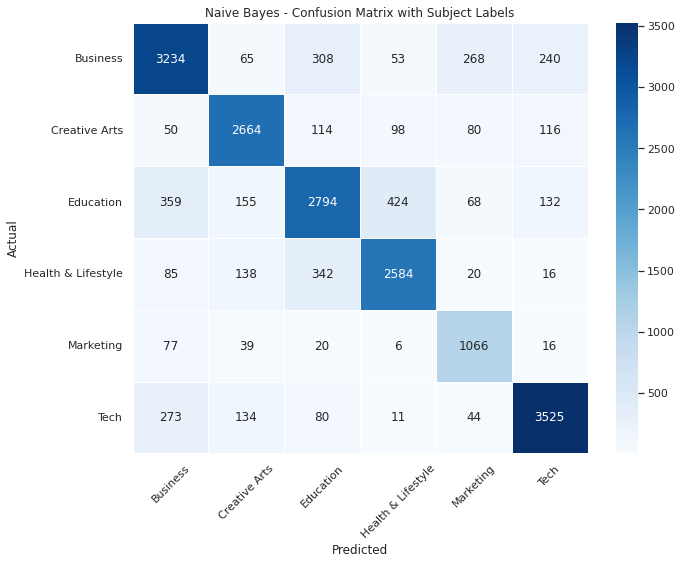

In [0]:
# Map numeric labels to subject names using existing label_dict
nb_preds_pd = nb_predictions.select("label", "prediction").toPandas()
nb_preds_pd["Actual"] = nb_preds_pd["label"].map(label_dict)
nb_preds_pd["Predicted"] = nb_preds_pd["prediction"].map(label_dict)

# Confusion Matrix (Counts)
cm_nb_named = pd.crosstab(nb_preds_pd["Actual"], nb_preds_pd["Predicted"], rownames=["Actual"], colnames=["Predicted"])

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm_nb_named, annot=True, fmt='d', cmap="Blues", linewidths=0.5)
plt.title("Naive Bayes - Confusion Matrix with Subject Labels")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



## **Summary:**

Naive Bayes Confusion Matrix
The confusion matrix shows how well the Naive Bayes model predicts course subjects.

High accuracy is observed for Tech (3,525 correct) and Business (3,234 correct).

Some confusion exists between similar fields like Education vs Health & Lifestyle, and Business vs Marketing.

Creative Arts performs reasonably well, but overlaps with other subjects.

Marketing has the fewest correct predictions, likely due to fewer training samples.

This visualization highlights strengths and areas for improvement in subject classification.

## Confusion Matrix Percentages - Naive Bayes

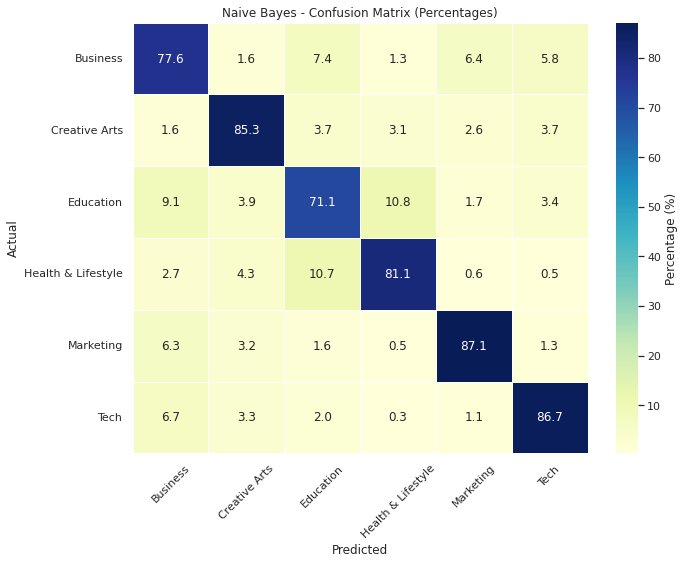

In [0]:
# Normalize to row-wise percentages
cm_nb_percent = cm_nb_named.div(cm_nb_named.sum(axis=1), axis=0) * 100
cm_nb_percent = cm_nb_percent.round(1)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm_nb_percent, annot=True, fmt='.1f', cmap="YlGnBu", linewidths=0.5, 
            cbar_kws={'label': 'Percentage (%)'})
plt.title("Naive Bayes - Confusion Matrix (Percentages)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



# **Confusion Matrix (Percentage) – Naive Bayes**

This heatmap displays the percentage of correct and incorrect predictions per subject, normalized by row (i.e., per actual class):

**High classification accuracy for:**

- Marketing (87.1%)

- Tech (86.7%)

- Creative Arts (85.3%)

- Health & Lifestyle (81.1%)

**Moderate accuracy for:**

- Business (77.6%)

- Education (71.1%)

**Most confusion occurs between:**

- Education vs Health & Lifestyle

- Business vs Education and Marketing

- Tech has small confusion with Business and Creative Arts

This matrix gives insight into which subjects are misclassified and to what degree, helping prioritize model refinement.

## Classification Report – Naive Bayes (Macro Averages)

In [0]:
# Convert to Spark if needed
df_pred = nb_predictions  # Already Spark

#  Get unique labels
labels = df_pred.select("label").distinct().rdd.flatMap(lambda x: x).collect()

#  Compute metrics
metrics = []
for cls in labels:
    tp = df_pred.filter((col("prediction") == cls) & (col("label") == cls)).count()
    fp = df_pred.filter((col("prediction") == cls) & (col("label") != cls)).count()
    fn = df_pred.filter((col("prediction") != cls) & (col("label") == cls)).count()
    support = df_pred.filter(col("label") == cls).count()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    metrics.append((cls, precision, recall, f1, support))

# Create Spark DataFrame
metrics_schema = ["class", "precision", "recall", "f1", "support"]
metrics_df = spark.createDataFrame(metrics, schema=metrics_schema)

#  Compute macro averages
macro_avg = metrics_df.select(
    avg("precision").alias("macro_precision"),
    avg("recall").alias("macro_recall"),
    avg("f1").alias("macro_f1")
)

# Step 6: Display
display(metrics_df)
display(macro_avg)


class precision recall f1 support 0.0 0.7930358018636586 0.775911708253359 0.7843803056027165 4168 1.0 0.8714462299134734 0.8667322350626998 0.8690828402366865 4067 4.0 0.8338028169014085 0.8532991672005125 0.8434383409846447 3122 3.0 0.8136020151133502 0.8113029827315542 0.8124508725043232 3185 2.0 0.7638053581191908 0.7105798575788402 0.7362318840579709 3932 5.0 0.6895213454075032 0.8709150326797386 0.7696750902527076 1224

macro_precision macro_recall macro_f1 0.7942022612197642 0.814790163917784 0.802543222273175

**This report provides precision, recall, and F1-score per subject label, alongside macro-averaged scores across all classes:**

 **Class-Level Metrics (Subject + Label ID):**

| Subject                | Label ID | Precision | Recall | F1 Score | Support | Interpretation                                                                                       |
| ---------------------- | -------- | --------- | ------ | -------- | ------- | ---------------------------------------------------------------------------------------------------- |
| **Business**           | 0        | 0.7931    | 0.7759 | 0.7844   | 4168    | Good overall accuracy; slightly more false negatives (missed business items).                        |
| **Tech**               | 1        | 0.8714    | 0.8667 | 0.8690   | 4067    | Excellent results—very few misclassifications.                                                       |
| **Education**          | 2        | 0.7638    | 0.7106 | 0.7362   | 3932    | Weaker recall—many educational items were misclassified.                                             |
| **Health & Lifestyle** | 3        | 0.8136    | 0.8113 | 0.8125   | 3185    | Balanced and strong performance.                                                                     |
| **Creative Arts**      | 4        | 0.8338    | 0.8533 | 0.8434   | 3122    | High recall—model captures most Creative Arts items correctly.                                       |
| **Marketing**          | 5        | 0.6895    | 0.8709 | 0.7697   | 1224    | High recall but low precision—many predictions were actually wrong, leading to more false positives. |





**Background Information:**

**Class-Level Metrics (Per Subject Label)**

- Each row represents a subject category (mapped by Label ID) and its classification performance, measured using:

- Precision: Out of all the predicted items for a subject, how many were actually correct.

- Recall: Out of all the actual items belonging to a subject, how many were correctly predicted.

- F1 Score: The harmonic mean of Precision and Recall. It balances both false positives and false negatives.

- Support: The number of true instances for each class in the dataset.

**Macro-Averaged Metrics**

**These are unweighted averages across all classes—useful when classes are imbalanced which is our case.**

| Metric              | Value  | Meaning                                                                                     |
| ------------------- | ------ | ------------------------------------------------------------------------------------------- |
| **Macro Precision** | 0.7942 | On average, 79.4% of items predicted per class are correct.                                 |
| **Macro Recall**    | 0.8148 | On average, 81.5% of actual class items were successfully detected.                         |
| **Macro F1 Score**  | 0.8025 | Balanced performance across all categories, with room to improve precision in some classes. |


**Key Takeaways**

- Tech and Creative Arts are the best-performing subjects.

- Education and Marketing need improvement. Education suffers from low recall, while Marketing suffers from low precision.

Despite class imbalances, macro-averaged F1 of ~0.80 indicates strong overall classification performance.

**Future suggestion:**  We should consider further improving predictions with more contextual features or better preprocessing (e.g., cleaning title noise or adding keyword embeddings).

## Reason for comapring the two evaluation methods—macro averages and 

## weighted (standard) averages



| Metric Type            | Macro Average (equal weight)                        | Weighted Average  |
| ---------------------- | --------------------------------------------------- | ------------------------------------------------------ |
| Focus                  | Class-level fairness                                | Overall performance                                    |
| Affected by Imbalance? | No                                                  | Yes (heavily influenced by dominant classes)           |
| Use Case               | When minority classes matter                        | When overall prediction rate matters                   |
| Logistic Example       | Lower than weighted                                 | Slightly higher due to dominance of large classes      |
| Naive Bayes Example    | Same structure; use macro to ensure fair evaluation |                                                        |



**Decision for  our Project:**

**Resoan for reporting both methods:**

Method 1: Macro Averages

- To highlight poor performance in smaller classes (e.g., Marketing).
- Fair treatment across categories matters.

Method 2: Weighted Averages: 

- General performance overview

- Comparison with common benchmarks